# More Examples
Notes based on http://deeplearning.net/software/theano/tutorial/examples.html.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from theano import function

### Logistic Function
The definition and a plot of the logistic function can be seen below. 

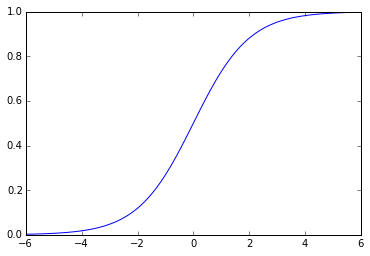

In [2]:
def sigmoid(x):
    x = 1 / (1 + np.exp(-x)) # also: T.exp(-x)
    return x

x = np.arange(-6, 6, 0.1)
plt.plot(x, sigmoid(x))

We compute this function elementwise, i.e. to each individual element, on matrices of doubles, as all of its operations (division, addition, exponentation) are elementwise operations:

In [3]:
x = T.dmatrix('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

Note:
\begin{equation}
s(x) = \frac{1}{1 + e^{-x}} = \frac{1 + \tanh(x/2)}{2}
\end{equation}

### Multiple Outputs
Theano supports functions with multiple outputs. For instance, we can compute the elementwise difference, absolute difference, and squared difference between two matrices $a$ and $b$ at the same time:

In [4]:
a, b = T.dmatrices('a', 'b')
diff = a - b
abs_diff = abs(diff)
diff_squared = diff**2
f = function([a, b], [diff, abs_diff, diff_squared])
f([[1, 1], [1, 1]], [[0, 1], [2, 3]])

[array([[ 1.,  0.],
        [-1., -2.]]), array([[ 1.,  0.],
        [ 1.,  2.]]), array([[ 1.,  0.],
        [ 1.,  4.]])]

### Defaults
You can set default values for arguments in theano using the __Param__ class like this:

In [5]:
from theano import Param
x, y = T.dscalars('x', 'y')
z = x + y
f = function([x, Param(y, default=1)], z)
f(33)

array(34.0)

Note: Like in Python, there can be multiple default inputs, they must follow inputs without default values, and can be set by name as well. The name attributes are the ones set by the TensorVariable initially, but can be overwritten, as seen below:

In [6]:
x, y, w = T.dscalars('x', 'y', 'w')
z = (x + y) * w
f = function([x, Param(y, default=1), Param(w, default=2, name='w_by_name')], z)
f(33, w_by_name=1, y=0)

array(33.0)

### Shared Variables
We can use the __shared__ function to construct so-called shared variables which share their value between multiple functions. An _accumulator_ function using __shared__ to store its internal state looks like this:

In [7]:
from theano import shared
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

We can access and modify the value of a shared variable using __.get_value()__ and __.set_value()__. The __updates__ parameter takes a list of pairs (or a dictionary) of the form (shared-variable, new expression). It is more efficient and more optimized for GPUs than doing the same in numpy. Whenever the function runs, __updates__ replaces the value of each shared variable with the result of the corresponding expression, as can be seen below:

In [8]:
state.get_value()

array(0)

In [9]:
accumulator(1)

array(0)

In [11]:
state.get_value()

array(1)

We can reset the state using __.set_value()__ like this:

In [13]:
state.set_value(-1)
accumulator(3)
state.get_value()

array(2)

As mentioned, other functions can use the shared variables as well:

In [15]:
decrementor = function([inc], state, updates=[(state, state-inc)])
decrementor(2)
state.get_value()

array(-2)

If a function is using a shared variable, but you do _not_ want to use its value, you can use the __givens__ parameter which replaces any part of your formula with a different expression that evaluates to a tensor of same shape and dtype:

In [17]:
fn_of_state = state * 2 + inc
foo = T.scalar(dtype=state.dtype) # same type as state
skip_shared = function([inc, foo], fn_of_state, givens=[(state, foo)])
skip_shared(1, 3) # 3 is used instead of state.value
state.get_value()

array(-2)

__givens__ can replace any variable, not just a shared one. The expressions introduced by __givens__ mustn't be co-dependent, as the substitutions have to work in any order.

### Using Random Numbers
To introduce randomness in your computation, Theano allocates a NumPy RandomStream object (a random number generator) for each random variable and draws from it as necessary. We call such a sequence of random numbers a _random stream_. Random streams are at their core shared variables, so all observations regarding shared variables hold here as well. Below, we create two random streams: __rv_u__, a random stream of 2x2 matrices drawing from a uniform distribution; and __rv_n__, a random stream of 2x2 matrices drawing from a normal distribution.

In [18]:
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)
rv_u = srng.uniform((2, 2))
rv_n = srng.normal((2, 2))
f = function([], rv_u)
g = function([], rv_n, no_default_updates=True) # not updating rv_n.rng
nearly_zeros = function([], rv_u + rv_u - 2 * rv_u)

As the internal state of our function __f__ is automatically updated, we get different random numbers every time.

In [22]:
f_val0 = f()
f_val1 = f()
f_val0, f_val1

(array([[ 0.28179047,  0.23616647],
        [ 0.5958365 ,  0.1385743 ]]), array([[ 0.4144294 ,  0.72942789],
        [ 0.24875205,  0.34337139]]))

Adding __no_default_updates=True__ to _g_ decouples the state from the random number generator, so we receive the same numbers every time.
Note that a random variable is drawn at most once during a single function execution. Thus, _nearly_zeros_ always returns 0, as the _rv_u_ is only executed once despicte appearing three times in the output expression.

In [26]:
nearly_zeros()

array([[ 0.,  0.],
       [ 0.,  0.]])

### Seeding Streams
We can seed random variables either individually or collectively by seeding the random number generator. Futhermore, we can seed _all_ random variables allocated by a __RandomStreams__ object by seeding that object.

In [29]:
rng_val = rv_u.rng.get_value(borrow=True) # get rng value of variable
rng_val.seed(89234) # seed generator
rv_u.rng.set_value(rng_val, borrow=True) # seed one random variable
srng.seed(902340) # seed rv_u and rv_n with different seeds each

### Sharing Streams Between Functions
As usual for shared variables, the random number generators are shared between functions. Thus each function call updates their state.

In [38]:
state_after_v0 = rv_u.rng.get_value().get_state()
nearly_zeros() # runs rv_u generator 1x
v1 = f() # runs rv_u generator the 2nd time
rng = rv_u.rng.get_value(borrow=True)
rng.set_state(state_after_v0) # reset state
rv_u.rng.set_value(rng, borrow=True)
v2 = f() # runs rv_u generator 1x
v3 = f() # runs rv_u generator the 2nd time
v3 == v1

array([[ True,  True],
       [ True,  True]], dtype=bool)

### Copying Random State Between Theano Graphs
In some cases, e.g. when trying to initialize the state of a model from the parameters of a pickled version of a previous model, you want to transfer the state of all random number generators associated with a given theano graph to a second graph. This can be done by copying elements of the _state_updates_ parameter, which contains a tuple for every time a random variable is drawn from the stream: the first element is a shared variable representing the state of the RNG associated with the drawn variable (__this is what we care about__), the second represents the theano graph associated with the RNG ( i.e. RandomFunction{uniform}.0).

In [40]:
from theano.sandbox.rng_mrg import MRG_RandomStreams

class Graph():
    def __init__(self, seed=123):
        self.rng = RandomStreams(seed)
        self.y = self.rng.uniform(size=(1,))

g1 = Graph(seed=123)
f1 = function([], g1.y)

g2 = Graph(seed=987)
f2 = function([], g2.y)

print 'By default, the two functions are out of sync.'
print 'f1() returns ', f1()
print 'f2() returns ', f2()

def copy_random_state(g1, g2):
    if isinstance(g1.rng, MRG_RandomStreams):
        g2.rng.rstate = g1.rng.rstate
    for (su1, su2) in zip(g1.rng.state_updates, g2.rng.state_updates):
        su2[0].set_value(su1[0].get_value())
        
print 'We now copy the state of the theano random number generators.'
copy_random_state(g1, g2)
print 'f1() returns ', f1()
print 'f2() returns ', f2()

By default, the two functions are out of sync.
f1() returns  [ 0.72803009]
f2() returns  [ 0.55056769]
We now copy the state of the theano random number generators.
f1() returns  [ 0.59044123]
f2() returns  [ 0.59044123]
